# Twitter Author Networks Analysis

This notebook performs a detailed analysis on different author networks that can be created with automatic keywords extracted from tweets using different data preprocessing approaches.

In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import xml.etree.ElementTree as ET
import itertools
from matplotlib import pyplot as plt
from itertools import combinations
import math

The author information is in a JSON array. Each element is a dictionary for a tweet that contains the tweet text, the tweet ID, and an anonymised author ID. We do not use the tweet text, only the IDs. This dataset does not contain the extracted keywords or sentiments.

In [2]:
with open('author_data.json', 'r') as openfile:
 
    # Reading from json file
    author_data = json.load(openfile)
    
author_data_list = list(author_data)

The processed tweets are in XML format, with an ID element, a sentiment element, and multiple keyword elements. The sentiment element contains a negative, neutral, positive, and compound score. The keyword elements each contain a local relevance score and the keyword itself.

The data is in different files based on the length of keywords. File 'conf1_1_combine.xml' contains 1-1 keywords, file 'conf1_2_combine.xml' contains 1-2 keywords, etc.

In [3]:
tree1_1 = ET.parse('conf1_1_combine.xml')
root1_1 = tree1_1.getroot()

tree1_2 = ET.parse('conf1_2_combine.xml')
root1_2 = tree1_2.getroot()

tree1_3 = ET.parse('conf1_3_combine.xml')
root1_3 = tree1_3.getroot()

tree2_2 = ET.parse('conf2_2_combine.xml')
root2_2 = tree2_2.getroot()

tree2_3 = ET.parse('conf2_3_combine.xml')
root2_3 = tree2_3.getroot()

tree3_3 = ET.parse('conf3_3_combine.xml')
root3_3 = tree3_3.getroot()

This function is used to select a subset of tweets based on their compound score sentiment:

In [4]:
def find_tweets(root, lower_compound_threshold, upper_compound_threshold):
    selected_tweets = []
    ind = 0
    for tweet in root:
        compound_score = float(tweet[1].text[tweet[1].text.find('compound')+11:tweet[1].text.find('}')])
        if compound_score < upper_compound_threshold and compound_score > lower_compound_threshold:
            selected_tweets.append(ind)
        ind += 1
    
    return selected_tweets

This function calculates the Jaccard similarity between two lists (to be used to calculate similarity in the keywords used by authors).

In [5]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

This function creates the author network based on the author data and the set of tweets and their keywords. Optionally, a set of 'noisy' keywords can be removed from consideration.

In [6]:
def create_author_graph(author_data, root, noisy_keywords):
    # authors and their keywords are tracked and similarity in pairs calculated
    author_keywords = dict()
    author_pair_connections = dict()
    
    # there can be a mismatch between the author data and tweets with keywords extracted/sentiment calculated
    root_indices = [root[i][0].text[1:-1] for i in range(len(root))]
    
    # looping through author data
    for tweet in author_data:
        tweet_id = tweet['id']
        author_id = tweet['author_id']
        
        try:
            # if author tweet is in analysed tweets
            tweet_index = root_indices.index(tweet_id)
            
            # getting the keywords from the tweet
            tweet_keywords = root[tweet_index][2:]
            tweet_keywords = [(lambda x: x.text[x.text.find(',')+3:x.text.find(')')-1])(x) for x in tweet_keywords]
            
            # if a keyword in a tweet is a subset of another keyword in the tweet, only the longer keyword is kept
            exclude_keywords = []
            for keyword_pair in list(combinations(tweet_keywords, 2)):
                if keyword_pair[0] in keyword_pair[1]:
                    exclude_keywords.append(keyword_pair[0])
                elif keyword_pair[1] in keyword_pair[0]:
                    exclude_keywords.append(keyword_pair[1])

            for keyword in exclude_keywords:
                if keyword in tweet_keywords:
                    tweet_keywords.remove(keyword)
            
            # noisy keywords are removed
            for keyword in noisy_keywords:
                if keyword in tweet_keywords:
                    tweet_keywords.remove(keyword)
            
            # author keywords are tracked
            if author_id in author_keywords:
                author_keywords[author_id] = set(tweet_keywords + list(author_keywords[author_id]))
            else:
                author_keywords[author_id] = tweet_keywords
        except:
            pass
    
    # calculating Jaccard similarity of keywords used by authors
    for author_pair in list(combinations(list(author_keywords.keys()), 2)):
        author0_keywords = author_keywords[author_pair[0]]
        author1_keywords = author_keywords[author_pair[1]]
        
        if len(author0_keywords) != 0 and len(author1_keywords) != 0:
            connection_strength = jaccard_similarity(author0_keywords, author1_keywords)
        
            author_pair_connections[frozenset(author_pair)] = connection_strength
        
    
    # creating graph with authors as nodes
    # edges are weighted based on similarity in author keywords
    G = nx.Graph()
    G.add_nodes_from(list(author_keywords.keys()))

    for edge_to_add in author_pair_connections:
        nodes = list(edge_to_add)
        G.add_edge(nodes[0], nodes[1], weight = author_pair_connections[edge_to_add])
        
    return G

Positive, negative, and neutral tweets are defined based on their compound score.

In [7]:
positive_tweets = find_tweets(root1_1, 0.05, 1)
negative_tweets = find_tweets(root1_1, -1, -0.05)
neutral_tweets = find_tweets(root1_1, -0.05, 0.05)

positive_tweets_add = find_tweets(root2_2, 0.05, 1)
negative_tweets_add = find_tweets(root2_2, -1, -0.05)
neutral_tweets_add = find_tweets(root2_2, -0.05, 0.05)

A set of noisy keywords is defined.

In [8]:
noisy_keywords = ['rt', 'amp', '…', 'co', 'https ://', '’', '.…']

All graphs are created:

In [9]:
all_graphs = {}

all_graphs['graph_pos_11'] = create_author_graph(author_data_list, [root1_1[i] for i in positive_tweets], [])
all_graphs['graph_neg_11'] = create_author_graph(author_data_list, [root1_1[i] for i in negative_tweets], [])
all_graphs['graph_neu_11'] = create_author_graph(author_data_list, [root1_1[i] for i in neutral_tweets], [])
all_graphs['graph_all_11'] = create_author_graph(author_data_list, root1_1, [])
    
all_graphs['graph_pos_12'] = create_author_graph(author_data_list, [root1_2[i] for i in positive_tweets], [])
all_graphs['graph_neg_12'] = create_author_graph(author_data_list, [root1_2[i] for i in negative_tweets], [])
all_graphs['graph_neu_12'] = create_author_graph(author_data_list, [root1_2[i] for i in neutral_tweets], [])
all_graphs['graph_all_12'] = create_author_graph(author_data_list, root1_2, [])
    
all_graphs['graph_pos_13'] = create_author_graph(author_data_list, [root1_3[i] for i in positive_tweets], [])
all_graphs['graph_neg_13'] = create_author_graph(author_data_list, [root1_3[i] for i in negative_tweets], [])
all_graphs['graph_neu_13'] = create_author_graph(author_data_list, [root1_3[i] for i in neutral_tweets], [])
all_graphs['graph_all_13'] = create_author_graph(author_data_list, root1_3, [])

all_graphs['graph_pos_22'] = create_author_graph(author_data_list, [root2_2[i] for i in positive_tweets_add], [])
all_graphs['graph_neg_22'] = create_author_graph(author_data_list, [root2_2[i] for i in negative_tweets_add], [])
all_graphs['graph_neu_22'] = create_author_graph(author_data_list, [root2_2[i] for i in neutral_tweets_add], [])
all_graphs['graph_all_22'] = create_author_graph(author_data_list, root2_2, [])

all_graphs['graph_pos_23'] = create_author_graph(author_data_list, [root2_3[i] for i in positive_tweets_add], [])
all_graphs['graph_neg_23'] = create_author_graph(author_data_list, [root2_3[i] for i in negative_tweets_add], [])
all_graphs['graph_neu_23'] = create_author_graph(author_data_list, [root2_3[i] for i in neutral_tweets_add], [])
all_graphs['graph_all_23'] = create_author_graph(author_data_list, root2_3, [])

all_graphs['graph_pos_33'] = create_author_graph(author_data_list, [root3_3[i] for i in positive_tweets_add], [])
all_graphs['graph_neg_33'] = create_author_graph(author_data_list, [root3_3[i] for i in negative_tweets_add], [])
all_graphs['graph_neu_33'] = create_author_graph(author_data_list, [root3_3[i] for i in neutral_tweets_add], [])
all_graphs['graph_all_33'] = create_author_graph(author_data_list, root3_3, [])

In [10]:
all_graphs['graph_pos_11_unnoisy'] = create_author_graph(author_data_list, [root1_1[i] for i in positive_tweets], noisy_keywords)
all_graphs['graph_neg_11_unnoisy'] = create_author_graph(author_data_list, [root1_1[i] for i in negative_tweets], noisy_keywords)
all_graphs['graph_neu_11_unnoisy'] = create_author_graph(author_data_list, [root1_1[i] for i in neutral_tweets], noisy_keywords)
all_graphs['graph_all_11_unnoisy'] = create_author_graph(author_data_list, root1_1, noisy_keywords)
    
all_graphs['graph_pos_12_unnoisy'] = create_author_graph(author_data_list, [root1_2[i] for i in positive_tweets], noisy_keywords)
all_graphs['graph_neg_12_unnoisy'] = create_author_graph(author_data_list, [root1_2[i] for i in negative_tweets], noisy_keywords)
all_graphs['graph_neu_12_unnoisy'] = create_author_graph(author_data_list, [root1_2[i] for i in neutral_tweets], noisy_keywords)
all_graphs['graph_all_12_unnoisy'] = create_author_graph(author_data_list, root1_2, noisy_keywords)
    
all_graphs['graph_pos_13_unnoisy'] = create_author_graph(author_data_list, [root1_3[i] for i in positive_tweets], noisy_keywords)
all_graphs['graph_neg_13_unnoisy'] = create_author_graph(author_data_list, [root1_3[i] for i in negative_tweets], noisy_keywords)
all_graphs['graph_neu_13_unnoisy'] = create_author_graph(author_data_list, [root1_3[i] for i in neutral_tweets], noisy_keywords)
all_graphs['graph_all_13_unnoisy'] = create_author_graph(author_data_list, root1_3, noisy_keywords)

all_graphs['graph_pos_22_unnoisy'] = create_author_graph(author_data_list, [root2_2[i] for i in positive_tweets_add], noisy_keywords)
all_graphs['graph_neg_22_unnoisy'] = create_author_graph(author_data_list, [root2_2[i] for i in negative_tweets_add], noisy_keywords)
all_graphs['graph_neu_22_unnoisy'] = create_author_graph(author_data_list, [root2_2[i] for i in neutral_tweets_add], noisy_keywords)
all_graphs['graph_all_22_unnoisy'] = create_author_graph(author_data_list, root2_2, noisy_keywords)

all_graphs['graph_pos_23_unnoisy'] = create_author_graph(author_data_list, [root2_3[i] for i in positive_tweets_add], noisy_keywords)
all_graphs['graph_neg_23_unnoisy'] = create_author_graph(author_data_list, [root2_3[i] for i in negative_tweets_add], noisy_keywords)
all_graphs['graph_neu_23_unnoisy'] = create_author_graph(author_data_list, [root2_3[i] for i in neutral_tweets_add], noisy_keywords)
all_graphs['graph_all_23_unnoisy'] = create_author_graph(author_data_list, root2_3, noisy_keywords)

all_graphs['graph_pos_33_unnoisy'] = create_author_graph(author_data_list, [root3_3[i] for i in positive_tweets_add], noisy_keywords)
all_graphs['graph_neg_33_unnoisy'] = create_author_graph(author_data_list, [root3_3[i] for i in negative_tweets_add], noisy_keywords)
all_graphs['graph_neu_33_unnoisy'] = create_author_graph(author_data_list, [root3_3[i] for i in neutral_tweets_add], noisy_keywords)
all_graphs['graph_all_33_unnoisy'] = create_author_graph(author_data_list, root3_3, noisy_keywords)

## Global Network Properties

We can create a properties table to see an overview of all graph statistics.

In [11]:
def generate_network_prop_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'nodes', 'edges', 'edge_weight', 'components'])
    for setup in graphs:
        graph = graphs[setup]
        num_nodes = len(graph.nodes())
        num_edges = len(graph.edges())
        edge_weight = graph.size(weight='weight')
        component_sizes = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'nodes': [num_nodes], 'edges': [num_edges]
                                            ,'edge_weight': [edge_weight], 'components': [component_sizes]})], ignore_index = True)
        
    return network_prop_df

In [12]:
generate_network_prop_table(all_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_pos_11,576,160461,4014.062354,"[567, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,graph_neg_11,559,150426,4806.938569,"[549, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2,graph_neu_11,681,222778,6528.078152,"[668, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,graph_all_11,872,372816,10198.547536,"[864, 1, 1, 1, 1, 1, 1, 1, 1]"
4,graph_pos_12,576,163878,2602.186029,"[573, 1, 1, 1]"
5,graph_neg_12,559,153735,3325.709791,"[555, 1, 1, 1, 1]"
6,graph_neu_12,681,226801,4473.914811,"[674, 1, 1, 1, 1, 1, 1, 1]"
7,graph_all_12,872,377146,7054.568114,"[869, 1, 1, 1]"
8,graph_pos_13,576,165025,2194.989681,"[575, 1]"
9,graph_neg_13,559,153735,2969.793767,"[555, 1, 1, 1, 1]"


We can also narrow down to just the networks created using all tweets.

In [13]:
all_tweet_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if 'all' in key]}

In [14]:
generate_network_prop_table(all_tweet_graphs).round(2)

,setup,nodes,edges,edge_weight,components
0,graph_all_11,872,372816,10198.55,"[864, 1, 1, 1, 1, 1, 1, 1, 1]"
1,graph_all_12,872,377146,7054.57,"[869, 1, 1, 1]"
2,graph_all_13,872,377146,6059.73,"[869, 1, 1, 1]"
3,graph_all_22,872,348195,1352.22,"[835, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
4,graph_all_23,872,359976,982.11,"[849, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
5,graph_all_33,872,267546,84.40,"[732, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
6,graph_all_11_unnoisy,872,372816,2362.94,"[864, 1, 1, 1, 1, 1, 1, 1, 1]"
7,graph_all_12_unnoisy,872,377146,1766.78,"[869, 1, 1, 1]"
8,graph_all_13_unnoisy,872,377146,1559.34,"[869, 1, 1, 1]"
9,graph_all_22_unnoisy,872,348195,596.95,"[835, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."


#### Centrality Distributions

In [15]:
pos_noisy_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if 'unnoisy' not in key and 'pos' in key]}
pos_unnoisy_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if 'unnoisy' in key and 'pos' in key]}

neg_noisy_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if 'unnoisy' not in key and 'neg' in key]}
neg_unnoisy_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if 'unnoisy' in key and 'neg' in key]}

neu_noisy_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if 'unnoisy' not in key and 'neu' in key]}
neu_unnoisy_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if 'unnoisy' in key and 'neu' in key]}

all_noisy_graphs = {key: all_tweet_graphs[key] for key in [key for key in all_tweet_graphs.keys() if 'unnoisy' not in key]}
all_unnoisy_graphs = {key: all_tweet_graphs[key] for key in [key for key in all_tweet_graphs.keys() if 'unnoisy' in key]}

In [16]:
def plot_graph_fun(graphs, fun, axis, offset, labels, sentiment, fun_arg = None):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        nx_fun = getattr(nx, fun)
        
        if fun_arg:
            fun_vals = sorted(list(nx_fun(graph, fun_arg).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        else:
            fun_vals = sorted(list(nx_fun(graph).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)
    
def plot_graph_strength(graphs, axis, labels, sentiment):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        fun_vals = sorted(list(dict(nx.degree(graph, weight = 'weight')).values()))
        cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)

We see that the degree centrality for the author networks does not provide any room for further analysis.

Text(0.5, 0.98, 'Degree Centrality distribution (Author network)')

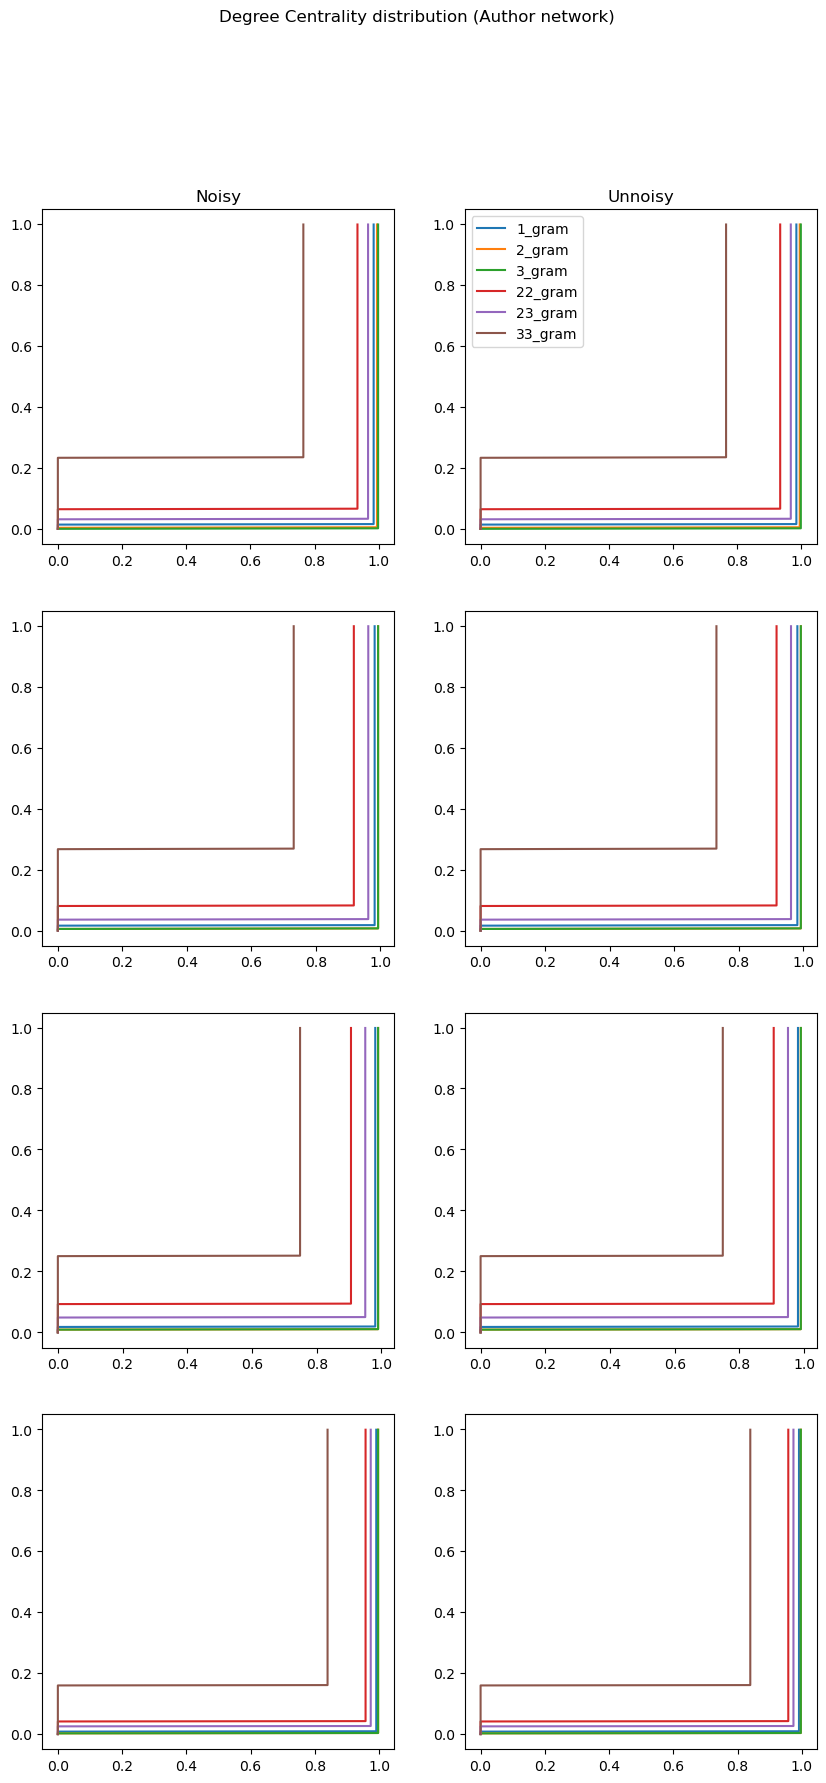

In [17]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (10, 20))

plot_graph_fun(pos_noisy_graphs, 'degree_centrality', axes[0,0], 1, ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], 'Noisy')
plot_graph_fun(pos_unnoisy_graphs, 'degree_centrality', axes[0,1], 1, ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], 'Unnoisy')

plot_graph_fun(neg_noisy_graphs, 'degree_centrality', axes[1,0], 1, ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')
plot_graph_fun(neg_unnoisy_graphs, 'degree_centrality', axes[1,1], 1, ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')

plot_graph_fun(neu_noisy_graphs, 'degree_centrality', axes[2,0], 1, ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')
plot_graph_fun(neu_unnoisy_graphs, 'degree_centrality', axes[2,1], 1, ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')

plot_graph_fun(all_noisy_graphs, 'degree_centrality', axes[3,0], 1, ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')
plot_graph_fun(all_unnoisy_graphs, 'degree_centrality', axes[3,1], 1, ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')


axes[0,1].legend()
fig.suptitle('Degree Centrality distribution (Author network)')

The node strength distributions are similar for all sentiments, an exception being the unnoisy neutral tweets network.

Text(0.5, 0.98, 'Node strength distribution (Author network)')

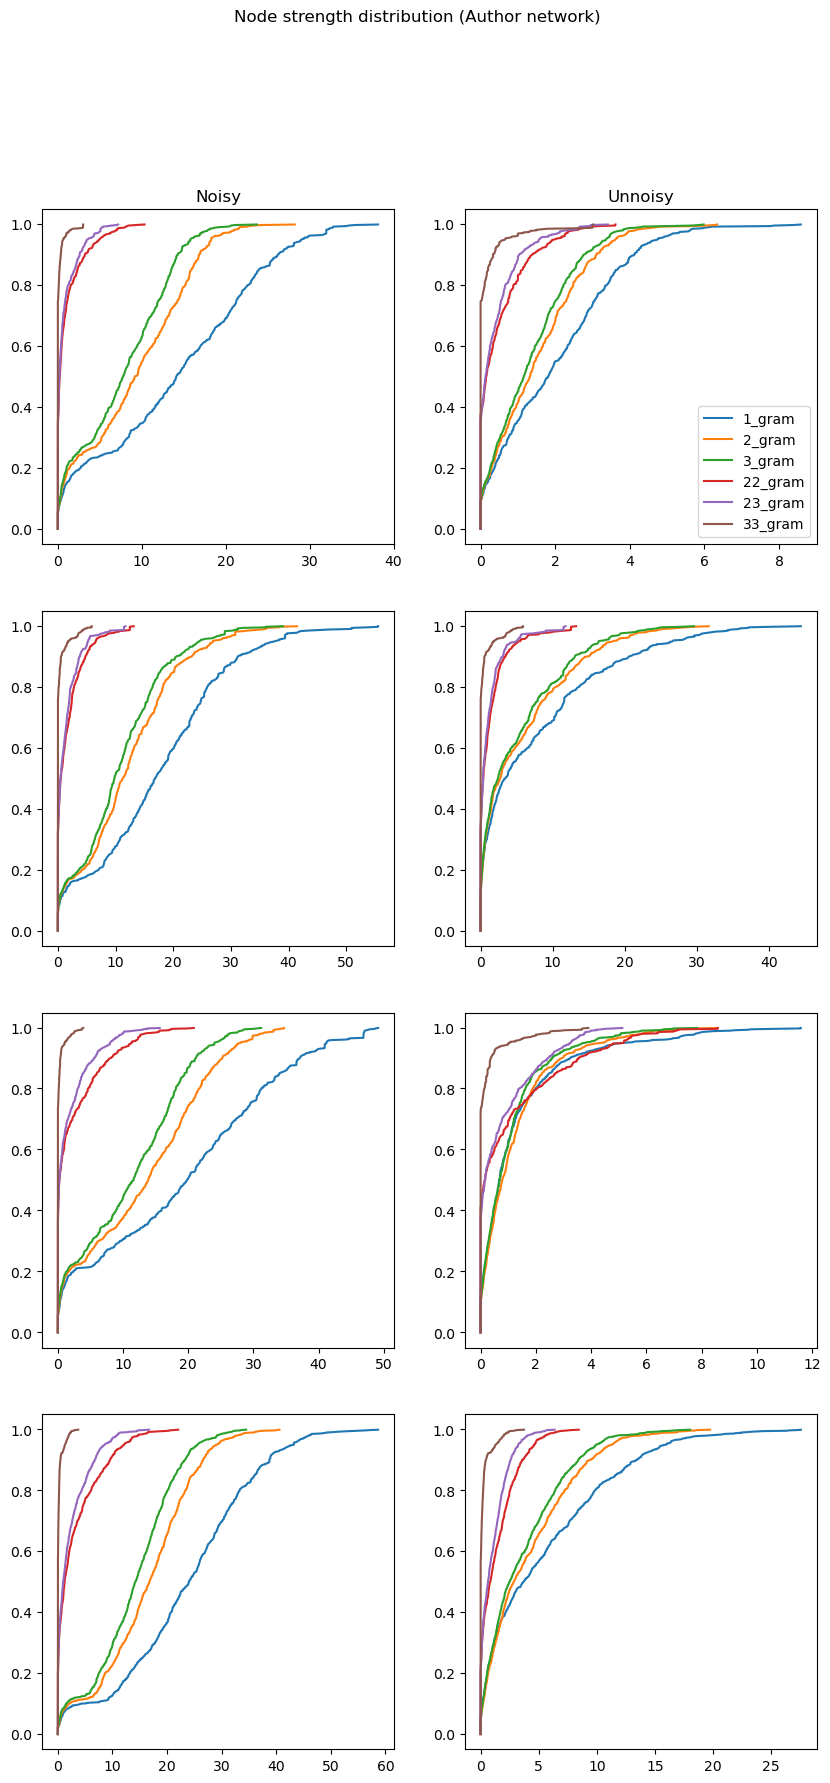

In [18]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (10, 20))

plot_graph_strength(pos_noisy_graphs, axes[0,0], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], 'Noisy')
plot_graph_strength(pos_unnoisy_graphs, axes[0,1], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], 'Unnoisy')

plot_graph_strength(neg_noisy_graphs, axes[1,0], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')
plot_graph_strength(neg_unnoisy_graphs, axes[1,1], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')

plot_graph_strength(neu_noisy_graphs, axes[2,0], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')
plot_graph_strength(neu_unnoisy_graphs, axes[2,1], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')

plot_graph_strength(all_noisy_graphs, axes[3,0], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')
plot_graph_strength(all_unnoisy_graphs, axes[3,1], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], '')


axes[0,1].legend()
fig.suptitle('Node strength distribution (Author network)')

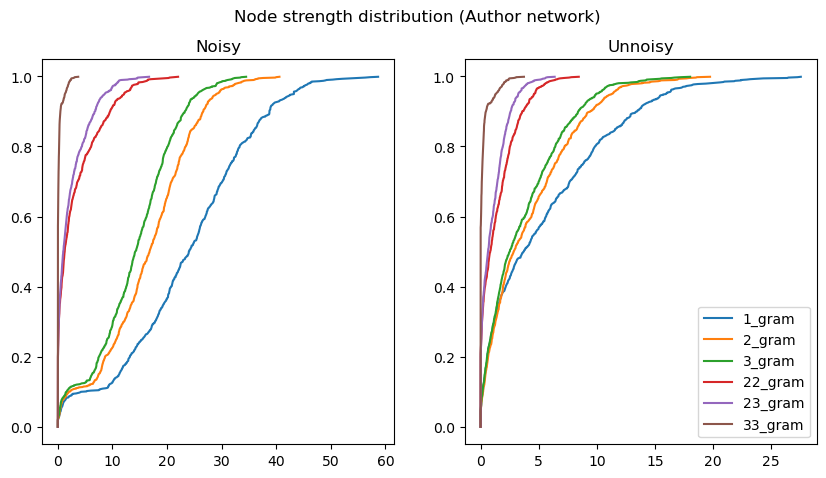

In [19]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

plot_graph_strength(all_noisy_graphs, axes[0], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], 'Noisy')
plot_graph_strength(all_unnoisy_graphs, axes[1], ['1_gram', '2_gram', '3_gram', '22_gram', '23_gram', '33_gram'], 'Unnoisy')


axes[1].legend()
fig.suptitle('Node strength distribution (Author network)')
plt.show()

#### Node Assortivity

We can also calculate network assortivity values, to see how nodes tend to connect to each other based on their strength.

In [20]:
# measuring the tendency of nodes to connect to each other based on certain attributes

def generate_network_assort_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'strength'])
    for setup in graphs:
        graph = graphs[setup]
        strength = nx.degree_assortativity_coefficient(graph, weight = 'weight')
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'strength': [strength]})], ignore_index = True)
        
    return network_prop_df

Assortivity values are all near 0.

In [21]:
# takes very long to run
generate_network_assort_table(all_tweet_graphs)

,setup,strength
0,graph_all_11,-0.001159
1,graph_all_12,-0.001152
2,graph_all_13,-0.001152
3,graph_all_22,-0.001199
4,graph_all_23,-0.001179
5,graph_all_33,-0.001368
6,graph_all_11_unnoisy,-0.001159
7,graph_all_12_unnoisy,-0.001152
8,graph_all_13_unnoisy,-0.001152
9,graph_all_22_unnoisy,-0.001199


## Node ranking

For each graph, we can rank nodes based on their node strength.

In [22]:
# the function ranks nodes in multiple graphs at once
# since graphs can have different numbers of nodes, we can limit how many of the top nodes are retained
def sorted_cent(graphs, topN):
    nodeStr_df = pd.DataFrame()
    
    for setup in graphs:
        
        graph = graphs[setup]
        #Computing node strength
        nodeStr = nx.degree(graph, weight = 'weight')
        nodeStr_sorted = dict(sorted(dict(nodeStr).items(), key=lambda item: item[1],reverse=True))
        
        nodeStr_df[setup] = list(nodeStr_sorted.keys())[0:topN]
        
    return nodeStr_df

In [23]:
nodeStr_rank_df = sorted_cent(all_graphs, 500)

Rank-based overlap (RBO) shows how similar two ranked lists are. The p value dictates how much weight is given to comparisons of higher ranked nodes. The weightage calculator calculates what percentage of the score comes from the first d elements in the lists.

In [24]:
def rbo(S,T, p= 0.9):
    """ Takes two lists S and T of any lengths and gives out the RBO Score
    Parameters
    ----------
    S, T : Lists (str, integers)
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1. Default 0.9 give the top 10 
        elements 86% of the contribution in the final score.
    
    Returns
    -------
    Float of RBO score
    """
    
    # Fixed Terms
    k = max(len(S), len(T))
    x_k = len(set(S).intersection(set(T)))
    
    summation_term = 0

    # Loop for summation
    # k+1 for the loop to reach the last element (at k) in the bigger list    
    for d in range (1, k+1): 
            # Create sets from the lists
            set1 = set(S[:d]) if d < len(S) else set(S)
            set2 = set(T[:d]) if d < len(T) else set(T)
            
            # Intersection at depth d
            x_d = len(set1.intersection(set2))

            # Agreement at depth d
            a_d = x_d/d   
            
            # Summation
            summation_term = summation_term + math.pow(p, d) * a_d

    # Rank Biased Overlap - extrapolated
    rbo_ext = (x_k/k) * math.pow(p, k) + ((1-p)/p * summation_term)

    return rbo_ext

def weightage_calculator(p,d):
    """ Takes values of p and d
    ----------
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1.
    d : depth at which the weight has to be calculated
    
    Returns
    -------
    Float of Weightage Wrbo at depth d
    """

    summation_term = 0

    for i in range (1, d): # taking d here will loop upto the value d-1 
        summation_term = summation_term + math.pow(p,i)/i


    Wrbo_1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - summation_term))

    return Wrbo_1_d

For a p value of 0.9, the top 13 nodes count for ~90% of the score; for a 0.99 p value, the top 130 count for ~90% of the score.

In [25]:
print(weightage_calculator(0.9, 13))
print(weightage_calculator(0.99, 130))

0.9079099164989892
0.9039562429806366


We calculate rank based overlap of networks created with all, positive, negative, and neutral tweets. We calculate these values for p values of 0.9 and 0.99. 

#### Node Strength Rankings

The shortlist ranking uses a p-value of 0.9 (meaning a smaller proportion of the rankings count towards the similarity score), while the longlist ranking uses a p-value of 0.99 (meaning a greateer proportion of the rankings count towards the score).

###### All Tweets

In [26]:
all_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'all' in x]]

In [27]:
nodeStr_shortlist_all_df = pd.DataFrame(columns = all_nodeStr_rank_df.columns, index = all_nodeStr_rank_df.columns)

for col1 in all_nodeStr_rank_df:
    for col2 in all_nodeStr_rank_df:
        nodeStr_shortlist_all_df[col1][col2] = rbo(all_nodeStr_rank_df[col1],all_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_all_df = nodeStr_shortlist_all_df.astype(float)

nodeStr_longlist_all_df = pd.DataFrame(columns = all_nodeStr_rank_df.columns, index = all_nodeStr_rank_df.columns)

for col1 in all_nodeStr_rank_df:
    for col2 in all_nodeStr_rank_df:
        nodeStr_longlist_all_df[col1][col2] = rbo(all_nodeStr_rank_df[col1],all_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_all_df = nodeStr_longlist_all_df.astype(float)

In [28]:
nodeStr_shortlist_all_df.round(3)

,graph_all_11,graph_all_12,graph_all_13,graph_all_22,graph_all_23,graph_all_33,graph_all_11_unnoisy,graph_all_12_unnoisy,graph_all_13_unnoisy,graph_all_22_unnoisy,graph_all_23_unnoisy,graph_all_33_unnoisy
graph_all_11,1.000,0.703,0.638,0.006,0.009,0.099,0.054,0.041,0.054,0.002,0.005,0.099
graph_all_12,0.703,1.000,0.716,0.066,0.034,0.099,0.076,0.084,0.085,0.019,0.019,0.099
graph_all_13,0.638,0.716,1.000,0.052,0.045,0.086,0.082,0.088,0.101,0.025,0.028,0.086
graph_all_22,0.006,0.066,0.052,1.000,0.840,0.001,0.033,0.041,0.030,0.160,0.075,0.001
graph_all_23,0.009,0.034,0.045,0.840,1.000,0.002,0.008,0.010,0.010,0.193,0.080,0.002
graph_all_33,0.099,0.099,0.086,0.001,0.002,1.000,0.001,0.002,0.003,0.032,0.054,1.000
graph_all_11_unnoisy,0.054,0.076,0.082,0.033,0.008,0.001,1.000,0.731,0.717,0.006,0.006,0.001
graph_all_12_unnoisy,0.041,0.084,0.088,0.041,0.010,0.002,0.731,1.000,0.851,0.011,0.012,0.002
graph_all_13_unnoisy,0.054,0.085,0.101,0.030,0.010,0.003,0.717,0.851,1.000,0.021,0.022,0.003
graph_all_22_unnoisy,0.002,0.019,0.025,0.160,0.193,0.032,0.006,0.011,0.021,1.000,0.775,0.032


In [29]:
nodeStr_longlist_all_df.round(3)

,graph_all_11,graph_all_12,graph_all_13,graph_all_22,graph_all_23,graph_all_33,graph_all_11_unnoisy,graph_all_12_unnoisy,graph_all_13_unnoisy,graph_all_22_unnoisy,graph_all_23_unnoisy,graph_all_33_unnoisy
graph_all_11,1.000,0.779,0.736,0.155,0.158,0.143,0.270,0.247,0.248,0.130,0.146,0.143
graph_all_12,0.779,1.000,0.881,0.254,0.249,0.148,0.287,0.294,0.291,0.169,0.183,0.148
graph_all_13,0.736,0.881,1.000,0.254,0.260,0.141,0.308,0.317,0.321,0.179,0.200,0.141
graph_all_22,0.155,0.254,0.254,1.000,0.892,0.131,0.119,0.141,0.143,0.334,0.295,0.131
graph_all_23,0.158,0.249,0.260,0.892,1.000,0.138,0.111,0.133,0.137,0.343,0.307,0.138
graph_all_33,0.143,0.148,0.141,0.131,0.138,1.000,0.123,0.137,0.137,0.206,0.251,1.000
graph_all_11_unnoisy,0.270,0.287,0.308,0.119,0.111,0.123,1.000,0.877,0.854,0.100,0.113,0.123
graph_all_12_unnoisy,0.247,0.294,0.317,0.141,0.133,0.137,0.877,1.000,0.936,0.123,0.139,0.137
graph_all_13_unnoisy,0.248,0.291,0.321,0.143,0.137,0.137,0.854,0.936,1.000,0.130,0.147,0.137
graph_all_22_unnoisy,0.130,0.169,0.179,0.334,0.343,0.206,0.100,0.123,0.130,1.000,0.855,0.206


###### Positive Tweets

In [30]:
pos_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'pos' in x]]

In [31]:
nodeStr_shortlist_pos_df = pd.DataFrame(columns = pos_nodeStr_rank_df.columns, index = pos_nodeStr_rank_df.columns)

for col1 in pos_nodeStr_rank_df:
    for col2 in pos_nodeStr_rank_df:
        nodeStr_shortlist_pos_df[col1][col2] = rbo(pos_nodeStr_rank_df[col1],pos_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_pos_df = nodeStr_shortlist_pos_df.astype(float)

nodeStr_longlist_pos_df = pd.DataFrame(columns = pos_nodeStr_rank_df.columns, index = pos_nodeStr_rank_df.columns)

for col1 in pos_nodeStr_rank_df:
    for col2 in pos_nodeStr_rank_df:
        nodeStr_longlist_pos_df[col1][col2] = rbo(pos_nodeStr_rank_df[col1],pos_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_pos_df = nodeStr_longlist_pos_df.astype(float)

In [32]:
nodeStr_shortlist_pos_df.round(3)

,graph_pos_11,graph_pos_12,graph_pos_13,graph_pos_22,graph_pos_23,graph_pos_33,graph_pos_11_unnoisy,graph_pos_12_unnoisy,graph_pos_13_unnoisy,graph_pos_22_unnoisy,graph_pos_23_unnoisy,graph_pos_33_unnoisy
graph_pos_11,1.000,0.500,0.501,0.004,0.004,0.009,0.005,0.023,0.031,0.043,0.058,0.009
graph_pos_12,0.500,1.000,0.830,0.114,0.115,0.005,0.007,0.031,0.033,0.088,0.067,0.005
graph_pos_13,0.501,0.830,1.000,0.162,0.162,0.008,0.008,0.037,0.050,0.147,0.120,0.008
graph_pos_22,0.004,0.114,0.162,1.000,0.741,0.003,0.008,0.008,0.008,0.035,0.005,0.003
graph_pos_23,0.004,0.115,0.162,0.741,1.000,0.006,0.007,0.009,0.009,0.037,0.007,0.006
graph_pos_33,0.009,0.005,0.008,0.003,0.006,1.000,0.016,0.048,0.065,0.313,0.618,1.000
graph_pos_11_unnoisy,0.005,0.007,0.008,0.008,0.007,0.016,1.000,0.734,0.670,0.012,0.017,0.016
graph_pos_12_unnoisy,0.023,0.031,0.037,0.008,0.009,0.048,0.734,1.000,0.908,0.084,0.085,0.048
graph_pos_13_unnoisy,0.031,0.033,0.050,0.008,0.009,0.065,0.670,0.908,1.000,0.125,0.132,0.065
graph_pos_22_unnoisy,0.043,0.088,0.147,0.035,0.037,0.313,0.012,0.084,0.125,1.000,0.587,0.313


In [33]:
nodeStr_longlist_pos_df.round(3)

,graph_pos_11,graph_pos_12,graph_pos_13,graph_pos_22,graph_pos_23,graph_pos_33,graph_pos_11_unnoisy,graph_pos_12_unnoisy,graph_pos_13_unnoisy,graph_pos_22_unnoisy,graph_pos_23_unnoisy,graph_pos_33_unnoisy
graph_pos_11,1.000,0.720,0.670,0.168,0.173,0.171,0.138,0.149,0.151,0.216,0.234,0.171
graph_pos_12,0.720,1.000,0.867,0.234,0.244,0.189,0.169,0.206,0.207,0.282,0.281,0.189
graph_pos_13,0.670,0.867,1.000,0.257,0.269,0.194,0.185,0.227,0.232,0.318,0.313,0.194
graph_pos_22,0.168,0.234,0.257,1.000,0.916,0.243,0.250,0.267,0.270,0.384,0.365,0.243
graph_pos_23,0.173,0.244,0.269,0.916,1.000,0.265,0.253,0.277,0.283,0.401,0.384,0.265
graph_pos_33,0.171,0.189,0.194,0.243,0.265,1.000,0.251,0.297,0.316,0.395,0.470,1.000
graph_pos_11_unnoisy,0.138,0.169,0.185,0.250,0.253,0.251,1.000,0.852,0.818,0.294,0.303,0.251
graph_pos_12_unnoisy,0.149,0.206,0.227,0.267,0.277,0.297,0.852,1.000,0.935,0.396,0.399,0.297
graph_pos_13_unnoisy,0.151,0.207,0.232,0.270,0.283,0.316,0.818,0.935,1.000,0.421,0.431,0.316
graph_pos_22_unnoisy,0.216,0.282,0.318,0.384,0.401,0.395,0.294,0.396,0.421,1.000,0.865,0.395


###### Negative Tweets

In [34]:
neg_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'neg' in x]]

In [35]:
nodeStr_shortlist_neg_df = pd.DataFrame(columns = neg_nodeStr_rank_df.columns, index = neg_nodeStr_rank_df.columns)

for col1 in neg_nodeStr_rank_df:
    for col2 in neg_nodeStr_rank_df:
        nodeStr_shortlist_neg_df[col1][col2] = rbo(neg_nodeStr_rank_df[col1],neg_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_neg_df = nodeStr_shortlist_neg_df.astype(float)

nodeStr_longlist_neg_df = pd.DataFrame(columns = neg_nodeStr_rank_df.columns, index = neg_nodeStr_rank_df.columns)

for col1 in neg_nodeStr_rank_df:
    for col2 in neg_nodeStr_rank_df:
        nodeStr_longlist_neg_df[col1][col2] = rbo(neg_nodeStr_rank_df[col1],neg_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_neg_df = nodeStr_longlist_neg_df.astype(float)

In [36]:
nodeStr_shortlist_neg_df.round(3)

,graph_neg_11,graph_neg_12,graph_neg_13,graph_neg_22,graph_neg_23,graph_neg_33,graph_neg_11_unnoisy,graph_neg_12_unnoisy,graph_neg_13_unnoisy,graph_neg_22_unnoisy,graph_neg_23_unnoisy,graph_neg_33_unnoisy
graph_neg_11,1.000,0.744,0.701,0.043,0.057,0.236,0.200,0.192,0.233,0.052,0.067,0.236
graph_neg_12,0.744,1.000,0.873,0.107,0.116,0.229,0.165,0.168,0.217,0.113,0.121,0.229
graph_neg_13,0.701,0.873,1.000,0.129,0.142,0.165,0.216,0.219,0.269,0.138,0.146,0.165
graph_neg_22,0.043,0.107,0.129,1.000,0.959,0.004,0.001,0.002,0.003,0.942,0.931,0.004
graph_neg_23,0.057,0.116,0.142,0.959,1.000,0.015,0.001,0.002,0.002,0.953,0.966,0.015
graph_neg_33,0.236,0.229,0.165,0.004,0.015,1.000,0.002,0.003,0.001,0.012,0.023,1.000
graph_neg_11_unnoisy,0.200,0.165,0.216,0.001,0.001,0.002,1.000,0.832,0.811,0.001,0.001,0.002
graph_neg_12_unnoisy,0.192,0.168,0.219,0.002,0.002,0.003,0.832,1.000,0.907,0.002,0.002,0.003
graph_neg_13_unnoisy,0.233,0.217,0.269,0.003,0.002,0.001,0.811,0.907,1.000,0.002,0.002,0.001
graph_neg_22_unnoisy,0.052,0.113,0.138,0.942,0.953,0.012,0.001,0.002,0.002,1.000,0.969,0.012


In [37]:
nodeStr_longlist_neg_df.round(3)

,graph_neg_11,graph_neg_12,graph_neg_13,graph_neg_22,graph_neg_23,graph_neg_33,graph_neg_11_unnoisy,graph_neg_12_unnoisy,graph_neg_13_unnoisy,graph_neg_22_unnoisy,graph_neg_23_unnoisy,graph_neg_33_unnoisy
graph_neg_11,1.000,0.867,0.839,0.337,0.353,0.257,0.492,0.508,0.507,0.360,0.368,0.257
graph_neg_12,0.867,1.000,0.930,0.385,0.399,0.256,0.483,0.509,0.513,0.405,0.410,0.256
graph_neg_13,0.839,0.930,1.000,0.407,0.426,0.233,0.496,0.524,0.531,0.428,0.433,0.233
graph_neg_22,0.337,0.385,0.407,1.000,0.925,0.233,0.209,0.237,0.245,0.755,0.746,0.233
graph_neg_23,0.353,0.399,0.426,0.925,1.000,0.268,0.215,0.243,0.250,0.780,0.790,0.268
graph_neg_33,0.257,0.256,0.233,0.233,0.268,1.000,0.176,0.179,0.170,0.265,0.300,1.000
graph_neg_11_unnoisy,0.492,0.483,0.496,0.209,0.215,0.176,1.000,0.910,0.893,0.244,0.247,0.176
graph_neg_12_unnoisy,0.508,0.509,0.524,0.237,0.243,0.179,0.910,1.000,0.947,0.272,0.272,0.179
graph_neg_13_unnoisy,0.507,0.513,0.531,0.245,0.250,0.170,0.893,0.947,1.000,0.277,0.278,0.170
graph_neg_22_unnoisy,0.360,0.405,0.428,0.755,0.780,0.265,0.244,0.272,0.277,1.000,0.933,0.265


###### Neutral Tweets

In [38]:
neu_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'neu' in x]]

In [39]:
nodeStr_shortlist_neu_df = pd.DataFrame(columns = neu_nodeStr_rank_df.columns, index = neu_nodeStr_rank_df.columns)

for col1 in neu_nodeStr_rank_df:
    for col2 in neu_nodeStr_rank_df:
        nodeStr_shortlist_neu_df[col1][col2] = rbo(neu_nodeStr_rank_df[col1],neu_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_neu_df = nodeStr_shortlist_neu_df.astype(float)

nodeStr_longlist_neu_df = pd.DataFrame(columns = neu_nodeStr_rank_df.columns, index = neu_nodeStr_rank_df.columns)

for col1 in neu_nodeStr_rank_df:
    for col2 in neu_nodeStr_rank_df:
        nodeStr_longlist_neu_df[col1][col2] = rbo(neu_nodeStr_rank_df[col1],neu_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_neu_df = nodeStr_longlist_neu_df.astype(float)

In [40]:
nodeStr_shortlist_neu_df.round(3)

,graph_neu_11,graph_neu_12,graph_neu_13,graph_neu_22,graph_neu_23,graph_neu_33,graph_neu_11_unnoisy,graph_neu_12_unnoisy,graph_neu_13_unnoisy,graph_neu_22_unnoisy,graph_neu_23_unnoisy,graph_neu_33_unnoisy
graph_neu_11,1.000,0.383,0.320,0.044,0.057,0.007,0.060,0.010,0.009,0.042,0.059,0.007
graph_neu_12,0.383,1.000,0.798,0.211,0.224,0.005,0.093,0.104,0.097,0.186,0.179,0.005
graph_neu_13,0.320,0.798,1.000,0.255,0.275,0.002,0.112,0.133,0.126,0.170,0.169,0.002
graph_neu_22,0.044,0.211,0.255,1.000,0.786,0.012,0.004,0.006,0.007,0.246,0.303,0.012
graph_neu_23,0.057,0.224,0.275,0.786,1.000,0.011,0.008,0.016,0.024,0.207,0.295,0.011
graph_neu_33,0.007,0.005,0.002,0.012,0.011,1.000,0.005,0.007,0.008,0.038,0.060,1.000
graph_neu_11_unnoisy,0.060,0.093,0.112,0.004,0.008,0.005,1.000,0.675,0.667,0.001,0.002,0.005
graph_neu_12_unnoisy,0.010,0.104,0.133,0.006,0.016,0.007,0.675,1.000,0.955,0.003,0.005,0.007
graph_neu_13_unnoisy,0.009,0.097,0.126,0.007,0.024,0.008,0.667,0.955,1.000,0.003,0.005,0.008
graph_neu_22_unnoisy,0.042,0.186,0.170,0.246,0.207,0.038,0.001,0.003,0.003,1.000,0.489,0.038


In [41]:
nodeStr_longlist_neu_df.round(3)

,graph_neu_11,graph_neu_12,graph_neu_13,graph_neu_22,graph_neu_23,graph_neu_33,graph_neu_11_unnoisy,graph_neu_12_unnoisy,graph_neu_13_unnoisy,graph_neu_22_unnoisy,graph_neu_23_unnoisy,graph_neu_33_unnoisy
graph_neu_11,1.000,0.714,0.642,0.181,0.184,0.126,0.167,0.175,0.173,0.196,0.206,0.126
graph_neu_12,0.714,1.000,0.855,0.276,0.279,0.139,0.217,0.239,0.234,0.240,0.238,0.139
graph_neu_13,0.642,0.855,1.000,0.299,0.308,0.130,0.234,0.257,0.253,0.226,0.230,0.130
graph_neu_22,0.181,0.276,0.299,1.000,0.893,0.219,0.167,0.242,0.237,0.421,0.414,0.219
graph_neu_23,0.184,0.279,0.308,0.893,1.000,0.226,0.179,0.256,0.258,0.397,0.406,0.226
graph_neu_33,0.126,0.139,0.130,0.219,0.226,1.000,0.216,0.246,0.263,0.274,0.334,1.000
graph_neu_11_unnoisy,0.167,0.217,0.234,0.167,0.179,0.216,1.000,0.810,0.802,0.188,0.204,0.216
graph_neu_12_unnoisy,0.175,0.239,0.257,0.242,0.256,0.246,0.810,1.000,0.948,0.295,0.312,0.246
graph_neu_13_unnoisy,0.173,0.234,0.253,0.237,0.258,0.263,0.802,0.948,1.000,0.293,0.320,0.263
graph_neu_22_unnoisy,0.196,0.240,0.226,0.421,0.397,0.274,0.188,0.295,0.293,1.000,0.801,0.274
